 # 0. Generate mesh in Python with Gmsh
 This notebook describes how to generate a mesh using Gmsh in Python. It requires PyGmsh to be installed:

 ```
 pip install pygmsh --user
 ```

 The mesh can also be generated from scratch directly in Gmsh either using its GUI and/or its internal scripting language.

 Note that `toughio` is not required at this preliminary stage of the pre-processing. This notebook only intends to show how the mesh used in this sample problem has been generated. The user is free to use any meshing software as long as the mesh format is supported by `toughio` (through `meshio`).

 The model geometry used for this sample problem is described in the paper:

 Cappa, Frédéric, and Jonny Rutqvist. "Modeling of Coupled Deformation and Permeability Evolution during Fault Reactivation Induced by Deep Underground Injection of CO<sub>2</sub>." International Journal of Greenhouse Gas Control 5, no. 2 (March 2011): 336–346. https://doi.org/10.1016/j.ijggc.2010.08.005.

 First, we import `numpy` and `pygmsh`, and initialize a `pygmsh.Geometry` object that will be used to construct all the geometrical entities of the model.

In [1]:
import numpy
import pygmsh

geo = pygmsh.built_in.Geometry()


 We can define a bunch of useful variables such as the characteristic length or some parameters to characterize the model.

In [2]:
lc = 100.0                              # Characteristic length of mesh
xmin, xmax = 0.0, 2000.0                # X axis boundaries
zmin, zmax = -500.0, -2500.0            # Z axis boundaries

inj_z = -1500.0                         # Depth of injection
flt_offset = 50.0                       # Offset of fault
flt_thick = 10.0                        # Thickness of fault
tana = numpy.tan(numpy.deg2rad(80.0))   # Tangeant of dipping angle of fault
dist = 500.0 - 0.5 * flt_thick          # Distance from injection point (0.0, -1500.0) to left wall of fault

bnd_thick = 10.0                        # Thickness of boundary elements


 We start by defining the geometrical entity representing the fault.
 The fault is represented as a finite-thickness element that intersects all the layers of the model.
 To ensure conformity of the final mesh, each wall of the fault is represented by a segmented line where the positions of the nodes correspond to the intersections of the hanging (left) and foot (right) walls with the different layers.
 Note that the foot wall is inverted so that the fault entity forms a closed rectangular loop.

In [3]:
depths = [zmin, -1300.0, -1450.0, -1550.0, -1700.0, zmax]
fault_left = [[dist + (z - inj_z) / tana, z, 0.0] for z in depths]

depths = [zmin, -1300.0 + flt_offset, -1450.0 + flt_offset, -1550.0 + flt_offset, -1700.0 + flt_offset, zmax]
fault_right = [[dist + (z - inj_z) / tana + flt_thick, z, 0.0] for z in depths]

fault = geo.add_polygon(
    X=fault_left + fault_right[::-1],
    lcar=0.1 * lc,
)


 Now, we define the aquifer located at the left side of the fault.
 To refine the mesh in the injection zone, the characteristic length of each layer entity is increased the farther we get from the injection point.
 Note that layers are defined such that their characteristic lengths are increasing. This is because Gmsh keeps the first node defined in the geometry in case it detects duplicated nodes.

In [4]:
cenaq_left = geo.add_polygon(
    X=[
        [xmin, -1450.0, 0.0],
        [dist + (-1450.0 - inj_z) / tana, -1450.0, 0.0],
        [dist + (-1550.0 - inj_z) / tana, -1550.0, 0.0],
        [xmin, -1550.0, 0.0],
    ],
    lcar=0.1 * lc,
)

capro_top_left = geo.add_polygon(
    X=[
        [xmin, -1300.0, 0.0],
        [dist + (-1300.0 - inj_z) / tana, -1300.0, 0.0],
        [dist + (-1450.0 - inj_z) / tana, -1450.0, 0.0],
        [xmin, -1450.0, 0.0],
    ],
    lcar=0.2 * lc,
)

capro_bot_left = geo.add_polygon(
    X=[
        [xmin, -1550.0, 0.0],
        [dist + (-1550.0 - inj_z) / tana, -1550.0, 0.0],
        [dist + (-1700.0 - inj_z) / tana, -1700.0, 0.0],
        [xmin, -1700.0, 0.0],
    ],
    lcar=0.2 * lc,
)

uppaq_left = geo.add_polygon(
    X=[
        [xmin, zmin, 0.0],
        [dist + (zmin - inj_z) / tana, zmin, 0.0],
        [dist + (-1300.0 - inj_z) / tana, -1300.0, 0.0],
        [xmin, -1300.0, 0.0],
    ],
    lcar=2.0 * lc,
)

basaq_left = geo.add_polygon(
    X=[
        [xmin, -1700.0, 0.0],
        [dist + (-1700.0 - inj_z) / tana, -1700.0, 0.0],
        [dist + (zmax - inj_z) / tana, zmax, 0.0],
        [xmin, zmax, 0.0],
    ],
    lcar=2.0 * lc,
)


 Likewise, we also define the aquifer located at the right side of the fault.

In [5]:
cenaq_right = geo.add_polygon(
    X=[
        [dist + (-1450.0 - inj_z + flt_offset) / tana + flt_thick, -1450.0 + flt_offset, 0.0],
        [xmax, -1450.0 + flt_offset, 0.0],
        [xmax, -1550.0 + flt_offset, 0.0],
        [dist + (-1550.0 - inj_z + flt_offset) / tana + flt_thick, -1550.0 + flt_offset, 0.0],
    ],
    lcar=0.75 * lc,
)

capro_top_right = geo.add_polygon(
    X=[
        [dist + (-1300.0 - inj_z + flt_offset) / tana + flt_thick, -1300.0 + flt_offset, 0.0],
        [xmax, -1300.0 + flt_offset, 0.0],
        [xmax, -1450.0 + flt_offset, 0.0],
        [dist + (-1450.0 - inj_z + flt_offset) / tana + flt_thick, -1450.0 + flt_offset, 0.0],
    ],
    lcar=0.75 * lc,
)

capro_bot_right = geo.add_polygon(
    X=[
        [dist + (-1550.0 - inj_z + flt_offset) / tana + flt_thick, -1550.0 + flt_offset, 0.0],
        [xmax, -1550.0 + flt_offset, 0.0],
        [xmax, -1700.0 + flt_offset, 0.0],
        [dist + (-1700.0 - inj_z + flt_offset) / tana + flt_thick, -1700.0 + flt_offset, 0.0],
    ],
    lcar=0.75 * lc,
)

uppaq_right = geo.add_polygon(
    X=[
        [dist + (zmin - inj_z) / tana + flt_thick, zmin, 0.0],
        [xmax, zmin, 0.0],
        [xmax, -1300.0 + flt_offset, 0.0],
        [dist + (-1300.0 - inj_z + flt_offset) / tana + flt_thick, -1300.0 + flt_offset, 0.0],
    ],
    lcar=2.0 * lc,
)

basaq_right = geo.add_polygon(
    X=[
        [dist + (-1700.0 - inj_z + flt_offset) / tana + flt_thick, -1700.0 + flt_offset, 0.0],
        [xmax, -1700.0 + flt_offset, 0.0],
        [xmax, zmax, 0.0],
        [dist + (zmax-inj_z) / tana + flt_thick, zmax, 0.0],
    ],
    lcar=2.0 * lc,
)


 Then, we define the boundary elements.
 In this sample problem, a no-flow boundary condition is imposed on the left side of the model (default in TOUGH), and Dirichlet boundary conditions are imposed elsewhere.
 Thus, physical boundary elements must be defined at the top, right and bottom sides of the model.
 Similarly to the fault entity, boundary entities are segmented to ensure conformity of the final mesh.

In [6]:
bound_right = geo.add_polygon(
    X=[
        [xmax, zmin, 0.0],
        [xmax + bnd_thick, zmin, 0.0],
        [xmax + bnd_thick, zmax, 0.0],
        [xmax, zmax, 0.0],
        [xmax, -1700.0 + flt_offset, 0.0],
        [xmax, -1550.0 + flt_offset, 0.0],
        [xmax, -1450.0 + flt_offset, 0.0],
        [xmax, -1300.0 + flt_offset, 0.0],
    ],
    lcar=lc,
)

bound_top = geo.add_polygon(
    X=[
        [xmin, zmin, 0.0],
        [dist + (zmin - inj_z) / tana, zmin, 0.0],
        [dist + (zmin - inj_z) / tana + flt_thick, zmin, 0.0],
        [xmax, zmin, 0.0],
        [xmax + bnd_thick, zmin, 0.0],
        [xmax + bnd_thick, zmin + bnd_thick, 0.0],
        [dist + (zmin - inj_z + bnd_thick) / tana + flt_thick, zmin + bnd_thick, 0.0],
        [dist + (zmin - inj_z + bnd_thick) / tana, zmin + bnd_thick, 0.0],
        [xmin, zmin + bnd_thick, 0.0],
    ],
    lcar=lc,
)

bound_bot = geo.add_polygon(
    X=[
        [xmin, zmax, 0.0],
        [dist + (zmax - inj_z) / tana, zmax, 0.0],
        [dist + (zmax - inj_z) / tana + flt_thick, zmax, 0.0],
        [xmax, zmax, 0.0],
        [xmax + bnd_thick, zmax, 0.0],
        [xmax + bnd_thick, zmax - bnd_thick, 0.0],
        [dist + (zmax - inj_z - bnd_thick) / tana + flt_thick, zmax - bnd_thick, 0.0],
        [dist + (zmax - inj_z - bnd_thick) / tana, zmax - bnd_thick, 0.0],
        [xmin, zmax - bnd_thick, 0.0],
    ],
    lcar=lc,
)


 Finally, we assign rock types/materials as Gmsh physical properties.

In [7]:
geo.add_physical(
    entities=[
        uppaq_left.surface,
        uppaq_right.surface,
    ],
    label="UPPAQ",
)
geo.add_physical(
    entities=[
        capro_top_left.surface,
        capro_bot_left.surface,
        capro_top_right.surface,
        capro_bot_right.surface,
    ],
    label="CAPRO",
)
geo.add_physical(
    entities=[
        cenaq_left.surface,
        cenaq_right.surface,
    ],
    label="CENAQ",
)
geo.add_physical(
    entities=[
        basaq_left.surface,
        basaq_right.surface,
    ],
    label="BASAQ",
)
geo.add_physical(
    entities=fault.surface,
    label = "FAULT",
)
geo.add_physical(
    entities=[
        bound_right.surface,
        bound_top.surface,
        bound_bot.surface,
    ],
    label="BOUND",
)


 Finally, we can generate the Gmsh mesh file directly in Python by specifying the path to Gmsh executable (if Gmsh has not been added to the system PATH).
 Alternatively, we can write the geometry file and import it in Gmsh to generate the final mesh:

 ```python
 with open("mesh.geo", "w") as f:
     f.write(geo.get_code())
 ```

In [8]:
geo.add_raw_code("Coherence;")
mesh = pygmsh.generate_mesh(
    geo,
    dim=2,
    prune_vertices=True,
    remove_lower_dim_cells=True,
    gmsh_path="gmsh",                   # Change the path here
    geo_filename="mesh.geo",
    msh_filename="mesh.msh",
    mesh_file_type="msh4",
    extra_gmsh_arguments=[
        # "-algo", "del2d",
        "-smooth", "2",
        "-optimize_netgen",
    ],
    verbose=False,
)



msh file: mesh.msh

geo file: mesh.geo


 The function `pygmsh.generate_mesh` returns a `meshio.Mesh` object that can be visualized with `pyvista`.

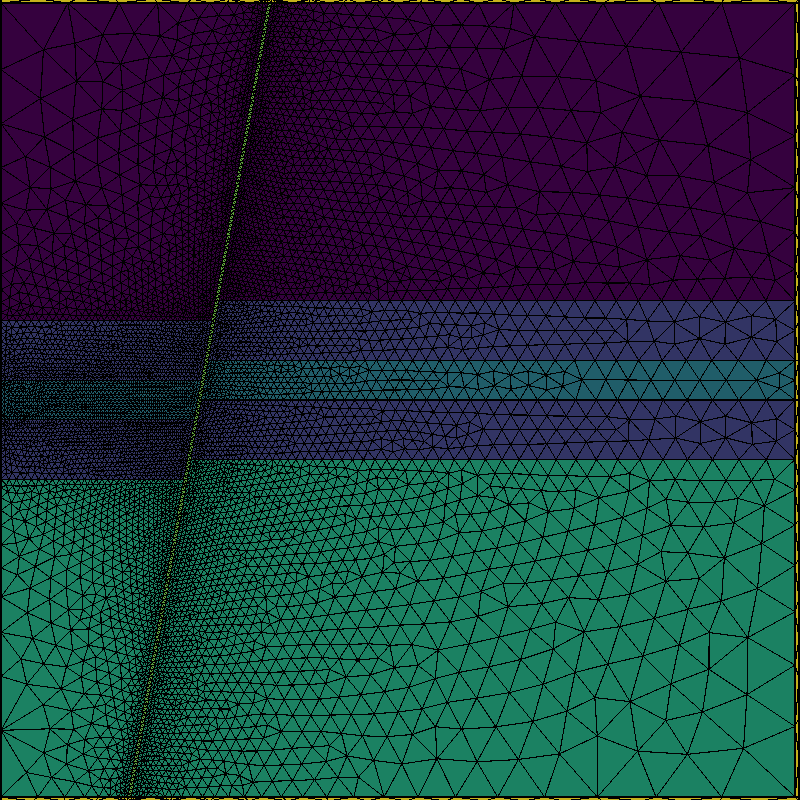

In [9]:
import pyvista
pyvista.set_plot_theme("document")

p = pyvista.Plotter(window_size=(800, 800), notebook=True)
p.add_mesh(
    mesh=pyvista.from_meshio(mesh),
    stitle="Materials",
    show_scalar_bar=False,
    show_edges=True,
)
p.camera_position = [
    (1005.0, -1500.0, 3760.0569123906835),
    (1005.0, -1500.0, 0.0),
    (0.0, 1.0, 0.0),
]
p.show()
